In [1]:
from util.de_utils import *
from util.class_def.de_obj_classes import *
from util.plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load data
* RNAseq data with TMM normalization
* Metadata
* DE data
    * Both general changes over time in preg
    * PE specific changes over time in preg

In [2]:
all_data = rnaseq_and_meta_data("../../data/rnaseq_discovery_data/sample_meta_postQC.csv", 
                                 "../../data/rnaseq_discovery_data/htseq_postQC.csv", 
                                 "../../data/rnaseq_discovery_data/TMM_postQC.csv",
                                mygene_db = mygene.MyGeneInfo())

de_PE = de_data("out/de/DE_PEspecific_changes_over_gestation.csv", alpha = 0.05, de_type = 'PE preg changes')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7041...done.
Finished.
15 input query terms found no hit:
	['ENSG00000133808', 'ENSG00000150076', 'ENSG00000155640', 'ENSG00000199837', 'ENSG00000213846', 'ENS
querying 1-15...done.
Finished.
8 input query terms found no hit:
	['AL356053.1', 'none', 'none', 'RP11-367G6.3', 'none', 'none', 'none', 'none']


In [3]:
#What kind of genes are DE in PE
all_data.rnaseq.anno.loc[de_PE.de.loc[de_PE.is_sig_mask].index].gene_type.value_counts()

protein_coding                        484
processed_pseudogene                   20
lncRNA                                 13
Mt_tRNA                                12
misc_RNA                               12
transcribed_processed_pseudogene        4
transcribed_unprocessed_pseudogene      3
unprocessed_pseudogene                  2
snoRNA                                  2
IG_C_gene                               2
scaRNA                                  1
polymorphic_pseudogene                  1
Name: gene_type, dtype: int64

# Understand DE trends over time
* In DE, modeled gestation (time) as natural cubic spline
* To understand when in gestation these changes occured, look at post-hoc logFC calculations

In [4]:
sig_genes = de_PE.de.index[de_PE.is_sig_mask]
term_logFC_sig = logFC_data_by_group(sig_genes, term_labels, CV_cutoff = 0.5, logFC_cutoff = 0.75)
term_logFC_sig.get_logFC_and_CI_by_group(all_data.rnaseq.logCPM.loc[sig_genes, :], all_data.meta)

Now calculating logFC for Early gestation
Now calculating logFC for Mid-gestation
Now calculating logFC for Late gestation
Now calculating logFC for Post-partum
Now estimating logFC confidence interval for Early gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Mid-gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Late gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Post-partum
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


# How do PE specific changes look over time in general
* What is the spread of logFC by time group
* Visualize DEGs where FC remains consistent based on 95% CI delta and CV at each time point
    * Defined consistent as logFC > 0 and CV(logFC) <= 0.5 (i.e., logFC varies by no more than half its average value for 95% of its plausible range)
    * Note we are only interested in one-sided uncertainty (that which approaches 0) since it matters less when some bootstrapped set yields more extreme logFC

Early gestation: 2 genes have CV greater than cutoff
Mid-gestation: 9 genes have CV greater than cutoff
Late gestation: 5 genes have CV greater than cutoff
Post-partum: 10 genes have CV greater than cutoff


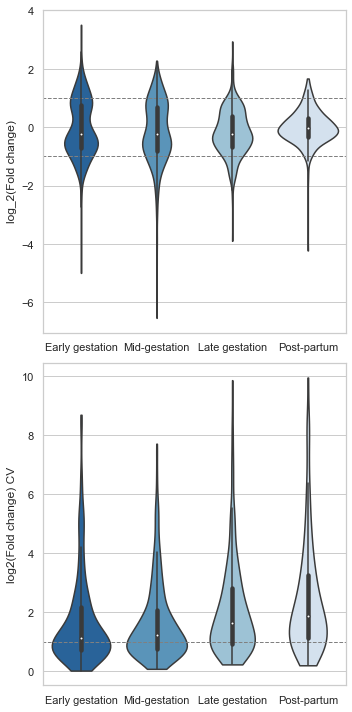

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (5, 10))

#Visualize logFC spread over time
ax[0].hlines([-1, 1], -1, 4, lw = 1, linestyle = 'dashed', color = 'gray')
sns.violinplot(x = 'variable', y = 'value', data = term_logFC_sig.logFC.iloc[:, :4].melt(), palette = 'Blues_r', inner = 'box', cut = 0, ax = ax[0])
ax[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax[0].set_xlabel("") 
ax[0].set_ylabel("log_2(Fold change)") #If use latex formatting to achieve subscripting, illustrator interprets text as pictures. So leave unformatted and format in illustrator for subscript

#Visualize 'coefficient of variation' = (delta_95CI / mean_logFC) over time. For some genes, CV is huge. Really interested in those where CV around 1 so cutoff plot at 10
melted_CV_frac = term_logFC_sig.CV.melt().dropna()
CV_plot_cutoff = 10

for time_pt in term_labels.values():
    print('%s: %d genes have CV greater than cutoff' % (time_pt, np.sum(melted_CV_frac.loc[melted_CV_frac.variable == time_pt, "value"] > CV_plot_cutoff)))

ax[1].hlines([1], -1, 4, lw = 1, linestyle = 'dashed', color = 'gray')
sns.violinplot(x = 'variable', y = 'value', inner = 'box', cut = 0, 
               data = melted_CV_frac.loc[melted_CV_frac.value <= CV_plot_cutoff], ax = ax[1], palette = 'Blues_r') 

ax[1].set_xlabel("")
ax[1].set_ylabel("log2(Fold change) CV")
ax[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

fig.tight_layout()

save_figure_pdf(fig, 'out/de/viz/DEG_logFC_CV.pdf')

# PE specific DEG clustering
* See if these DEGs cluster PE vs normotensive at each time point

In [6]:
## Normalize data for plotting using zscorse
#Get 1 sample per subj per time_group
samples_term = {term_labels[time_group] : meta_term.drop_duplicates(subset = 'subject', keep = 'first').index.to_list() for time_group, meta_term in all_data.meta.groupby('term')}

zscores_by_term = {}
pe_sig_terms = {}

min_zscore = None
max_zscore = None

for time_group, samples in samples_term.items():
    #Zscore scale data
    logCPM_term = all_data.rnaseq.logCPM.loc[:, samples].T
    zscores_by_term[time_group] = preprocess_data(StandardScaler().fit(logCPM_term), logCPM_term).T
    
    #Get genes that pass CV and logFC threshold
    pe_sig_terms[time_group] = sig_genes[np.logical_and(term_logFC_sig.CV_mask.loc[:, time_group], term_logFC_sig.logFC_mask.loc[:, time_group])]
    
    #Get min and max axs time groups for unified plotting
    curr_time_min_zscore = np.min(zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].to_numpy().flatten())
    curr_time_max_zscore = np.max(zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].to_numpy().flatten())
    
    min_zscore = curr_time_min_zscore if ((min_zscore is None) or (curr_time_min_zscore < min_zscore)) else min_zscore
    max_zscore = curr_time_max_zscore if ((max_zscore is None) or (curr_time_max_zscore > min_zscore)) else max_zscore

Early gestation: N DE genes used = 51, N samples = 27
Mid-gestation: N DE genes used = 38, N samples = 28
Late gestation: N DE genes used = 17, N samples = 31
Post-partum: N DE genes used = 14, N samples = 30


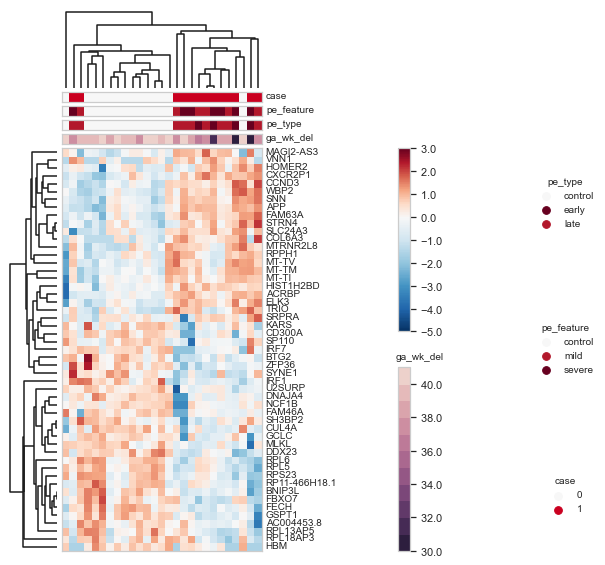

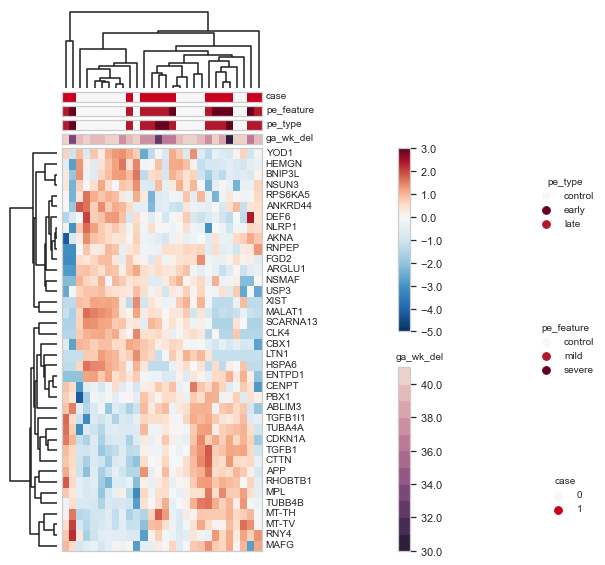

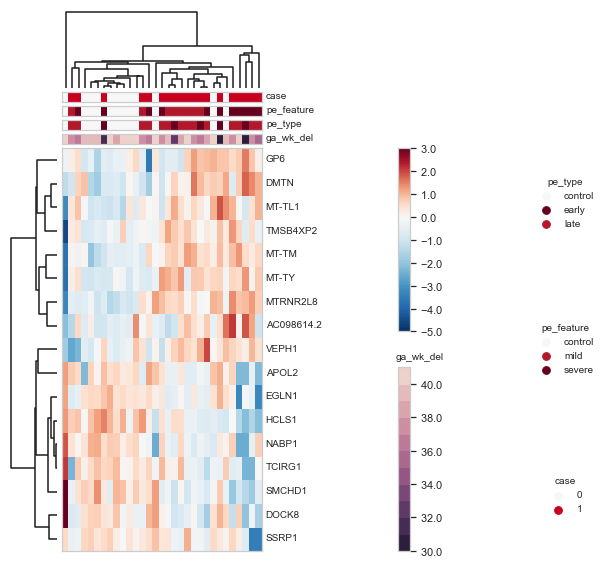

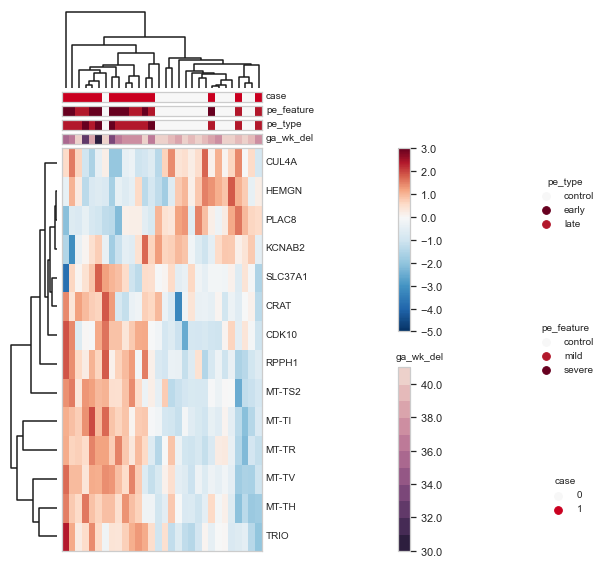

In [7]:
cmaps = {"case" : make_color_map("", ['#f7f7f7', '#ca0020']),
         'pe_feature' : make_color_map("", pe_feat_palette),
        "pe_type" : make_color_map("", pe_type_palette),
        "ga_wk_del" : make_color_map("", sns.cubehelix_palette(len(all_data.meta.ga_wk_del.unique()), reverse = True).as_hex())}

zscore_cbar_params = {'min' : np.floor(min_zscore), 'mid' : 0, 'max' : np.ceil(max_zscore)} #So that color bar is consistent across figures 

for time_group, samples in samples_term.items():  
    meta_term = all_data.meta.loc[samples]
    meta_term.loc[:, 'case'] = meta_term.case.astype(str)

    zscores_to_plot = zscores_by_term[time_group].loc[pe_sig_terms[time_group], :].reset_index('gene_num', drop = True)
    print("%s: N DE genes used = %d, N samples = %s" % (time_group, zscores_to_plot.shape[0], meta_term.shape[0]))
    fig, _ = nhm_plot_heatmap(zscores_to_plot, dfc = meta_term.loc[:, list(cmaps.keys())], cmaps = cmaps, center_args = zscore_cbar_params)
    save_figure_pdf(fig, 'out/de/viz/' + time_group.replace(" ", "_") + "_cluster.pdf")

N DE genes used = 51, N samples = 28
N DE genes used = 51, N samples = 31
N DE genes used = 51, N samples = 30
N DE genes used = 38, N samples = 27
N DE genes used = 38, N samples = 31
N DE genes used = 38, N samples = 30
N DE genes used = 17, N samples = 27
N DE genes used = 17, N samples = 28
N DE genes used = 17, N samples = 30
N DE genes used = 14, N samples = 27
N DE genes used = 14, N samples = 28
N DE genes used = 14, N samples = 31


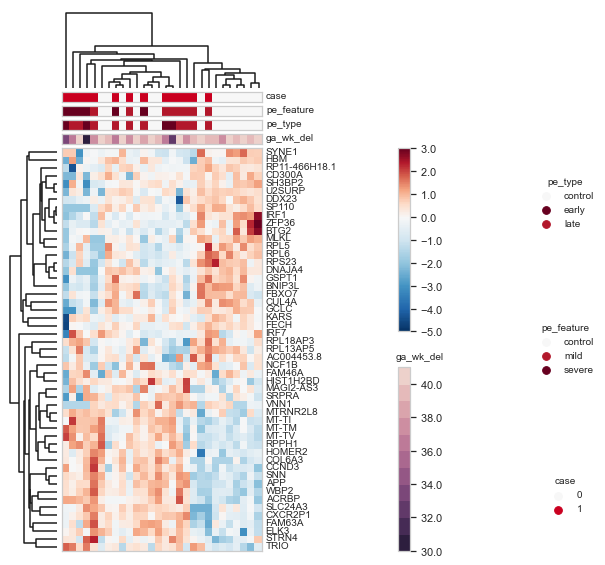

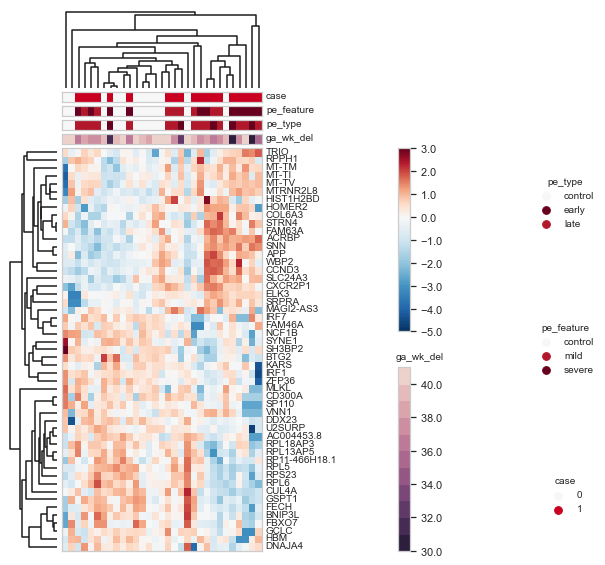

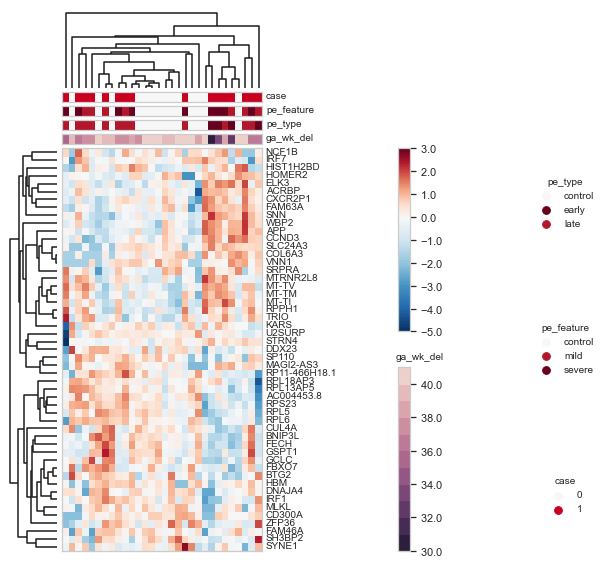

In [ ]:
#For supplement
#See if genes from 1 term can cluster samples from other terms
for term in term_labels.values():
    for other_term, samples in samples_term.items(): 
        if other_term == term:
            continue
        
        meta_term = all_data.meta.loc[samples]
        meta_term.loc[:, 'case'] = meta_term.case.astype(str)
        
        zscores_to_plot = zscores_by_term[other_term].loc[pe_sig_terms[term], :].reset_index('gene_num', drop = True)
        print("N DE genes used = %d, N samples = %s" % (zscores_to_plot.shape[0], meta_term.shape[0]))
        fig, _ = nhm_plot_heatmap(zscores_to_plot, dfc = meta_term.loc[:, list(cmaps.keys())], cmaps = cmaps, center_args = zscore_cbar_params)
        save_figure_pdf(fig, 'out/de/viz/cross_cluster/' + term.replace(" ", "_") + "_DEGs_cluster_" + other_term.replace(" ", "_") + ".pdf")

# K-means cluster
* Understand time trends

In [ ]:
kmeans = kmeans_cluster(term_logFC_sig.logFC, n_max_clusters = 4**2) #4 time points with 2 possibiliites at each (DE or not)
save_figure_pdf(fig, 'out/de/viz/DE_kmeans_nClusters_QC.pdf')

In [ ]:
fig, ax = plt.subplots()

plt.hlines(0, -1, 5, linestyle = 'dashed', color = 'gray', lw = 1)

sns.lineplot(x = 'time', y = 'log2FC', hue = 'kmeans_cluster', style = 'kmeans_cluster', 
             data = term_logFC_sig.logFC.join(kmeans['clusters']).melt(id_vars='kmeans_cluster', var_name = 'time', value_name = 'log2FC'),
             sort = False, seed = 37, ci = 95, n_boot = 1000, lw = 1, palette = 'dark',
             markers = {cluster_i : 'o' for cluster_i in np.arange(1, kmeans['n_clusters'] + 1)}, dashes = False)

plt.xlabel("")
plt.ylabel("log2FC")

h,l = ax.get_legend_handles_labels()
plt.legend(h[1:], l[1:], ncol = 3, frameon=0, bbox_to_anchor=(1.03, 1.12)) #[1, :] removes legend title
save_figure_pdf(fig, 'out/de/viz/DE_kmeans_clusters.pdf')

# GO Analysis

In [ ]:
#Get GO queries - 1 per kmeans cluster
go_queries = {str(cluster_i) : kmeans['clusters'].loc[kmeans['clusters'] == cluster_i].index.get_level_values('gene_num').to_list() for cluster_i in np.arange(1, kmeans['n_clusters'] + 1)}

In [ ]:
go_table, go_table_pruned = get_and_prune_go_table(go_queries, organism = 'hsapiens', 
                                                               sources = ["GO:MF","GO:BP","KEGG","REAC","HPA", "HP"], 
                                                               domain_scope = 'annotated', no_evidences = False, no_iea = False)

In [ ]:
sources_to_include = ['GO:BP', 'REAC', 'HP', 'HPA'] 

plot_colorbar = True

for source in sources_to_include:
    if go_table_pruned.loc[go_table_pruned.source.isin([source])].shape[0] == 0:
        continue

    go_table_pruned_to_plot = -1*np.log10(go_table_pruned.loc[go_table_pruned.source.isin([source]), ['name', 'query', 'p_value']].pivot(index = 'query', columns = 'name', values = 'p_value')).fillna(0)
    go_table_pruned_to_plot = go_table_pruned_to_plot.loc[:, go_table_pruned.loc[go_table_pruned.source.isin([source])].name]
    go_table_pruned_to_plot = go_table_pruned_to_plot.loc[:, ~go_table_pruned_to_plot.columns.duplicated()]

    #Insert keys that did not have any sig GO terms
    for key in go_table_pruned_to_plot.index.categories:
        if key in go_table_pruned_to_plot.index:
            continue
        go_table_pruned_to_plot.loc[key, :] = 0
    go_table_pruned_to_plot.sort_index(inplace = True)

    fig, ax = plt.subplots(1, figsize = (30, 10))
    sns.heatmap(go_table_pruned_to_plot, 
                mask = (go_table_pruned_to_plot == 0),
                square = True, xticklabels = True, yticklabels = True, linewidths = 1, cmap = 'rocket', linecolor = 'black',
                cbar_kws={"shrink": 0.4}, vmin = 0, vmax = np.round(np.max(-1*np.log10(go_table_pruned.p_value.to_numpy()))), 
                cbar = plot_colorbar, ax = ax)

    plt.title(source)
    plt.xlabel('')
    plt.ylabel('')

    fig.tight_layout()   
    save_figure_pdf(fig, "out/de/viz/" + source.replace(":", "-") + "_GO.pdf")